In [1]:
import os
os.chdir('..')

In [2]:
%load_ext autoreload
%autoreload 2

import scipy.stats as stats 
import numpy as np
import pandas as pd
import torch
import random
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time
from tqdm import tqdm
from pathlib import Path
from hac.model import HACModel

from hac.utils.key_points import W_LIST_POSE, W2I_POSE, \
                                 W_LIST_LEFT_HAND, W2I_LEFT_HAND, \
                                 W_LIST_RIGHT_HAND, W2I_RIGHT_HAND, \
                                 X_COLS, Y_COLS, \
                                 ALL_XY_COLS, HAND_XY_COLS, \
                                 LEFT_HAND_X_COLS, LEFT_HAND_Y_COLS, \
                                 RIGHT_HAND_X_COLS, RIGHT_HAND_Y_COLS
from hac.utils.normalizer import normalize_data, normalize_hand_data

In [3]:
os.getcwd()

'C:\\Users\\JAQQ\\YOLO\\hac'

In [4]:
torch.random.manual_seed(5566)
np.random.seed(5566)
random.seed(5566)

In [5]:
data_path = "data\\actions"
model_target = "gestures"

if model_target == "actions":
    mode = "pose_hand"
    model_name = "roblox_lift_game"
    actions = ["walk", "jump", "hands_on_hips", "point_left", "point_right", "arms_lift", "punch", "trample", "lateral_raise", "stand"]
    target_columns_x = ALL_XY_COLS.copy()
    ALL_XY_COLS += ["image_name", "label"] # keep label
elif model_target == "gestures":
    mode = "hand"
    model_name = "mouse"
    actions = ["r_five", "r_zero", "l_five", "l_zero", "two_index_fingers_up", "two_index_fingers_down", "33", "55", "sit"]
    target_columns_x = HAND_XY_COLS.copy()
    HAND_XY_COLS += ["image_name", "label"] # keep label
else:
    RunTimeError("???")

dfs = []
for idx, action in enumerate(actions):
    file_path = os.path.join(data_path, action, "data.csv")
    print(file_path)
    df = pd.read_csv(file_path)

    df.label = idx
    dfs.append(df)

data\actions\r_five\data.csv
data\actions\r_zero\data.csv
data\actions\l_five\data.csv
data\actions\l_zero\data.csv
data\actions\two_index_fingers_up\data.csv
data\actions\two_index_fingers_down\data.csv
data\actions\33\data.csv
data\actions\55\data.csv
data\actions\sit\data.csv


In [6]:
df_train = pd.concat(dfs)
df_train = df_train.reset_index(drop=True)
df_train

,n_x,n_y,n_v,lei_x,lei_y,lei_v,le_x,le_y,le_v,leo_x,...,r_p_p_y,r_p_p_v,r_p_d_x,r_p_d_y,r_p_d_v,r_p_t_x,r_p_t_y,r_p_t_v,image_name,label
0,0.569559,0.515890,0.999972,0.591710,0.552451,0.999902,0.602856,0.548133,0.999926,0.616494,...,0.513827,0.0,0.323141,0.547200,0.0,0.321647,0.579914,0.0,1626748318621.png,0
1,0.555219,0.507870,0.999974,0.577608,0.545067,0.999904,0.589006,0.540769,0.999931,0.602398,...,0.514952,0.0,0.322457,0.547779,0.0,0.320947,0.578922,0.0,1626748318702.png,0
2,0.552745,0.499431,0.999976,0.574333,0.537147,0.999909,0.586843,0.533208,0.999936,0.599682,...,0.513422,0.0,0.321527,0.546173,0.0,0.319171,0.577866,0.0,1626748318764.png,0
3,0.554274,0.496619,0.999977,0.575574,0.534501,0.999912,0.588492,0.530744,0.999940,0.600943,...,0.513384,0.0,0.321117,0.545780,0.0,0.318958,0.576631,0.0,1626748318827.png,0
4,0.552750,0.497576,0.999979,0.574484,0.535510,0.999915,0.587696,0.531233,0.999944,0.599823,...,0.510619,0.0,0.320460,0.542802,0.0,0.317962,0.573710,0.0,1626748318889.png,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5044,0.474786,0.569185,0.999659,0.490803,0.615465,0.999523,0.505444,0.614216,0.999281,0.517959,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1626749480950.png,8
5045,0.474342,0.569941,0.999677,0.489896,0.615798,0.999550,0.504581,0.614885,0.999315,0.516979,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1626749481011.png,8
5046,0.473217,0.569113,0.999684,0.488396,0.615158,0.999562,0.502899,0.614612,0.999323,0.515308,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1626749481074.png,8
5047,0.472520,0.569116,0.999689,0.487926,0.615118,0.999566,0.502519,0.614611,0.999327,0.514899,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1626749481136.png,8


In [7]:
if model_target == "actions":
    df_train = normalize_data(df_train)
    display(df_train)
if model_target == "gestures":
    df_train = normalize_hand_data(df_train)
    display(df_train)

,l_w_x,l_t_c_x,l_t_m_x,l_t_i_x,l_t_t_x,l_i_m_x,l_i_p_x,l_i_d_x,l_i_t_x,l_m_m_x,...,r_r_m_v,r_r_p_v,r_r_d_v,r_r_t_v,r_p_m_v,r_p_p_v,r_p_d_v,r_p_t_v,image_name,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626748318621.png,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626748318702.png,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626748318764.png,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626748318827.png,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626748318889.png,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626749480950.png,8
5045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626749481011.png,8
5046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626749481074.png,8
5047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1626749481136.png,8


In [8]:
#df_train_x = df_train[target_columns_x]
#df_train_y = df_train["label"]
#df_train_image = df_train["image_name"]

In [9]:
'''class Graph:
        
    def __init__(self, 
                 k_hop, mode):
        
        """
        inputs:
            mode: "hand", "pose", "pose_hand"
        """
        
        self.k_hop = k_hop
        self.mode = mode
        
        self.create_vertex()
        self.create_edge()
        self.create_adjacent_matrix()
        self.create_D()
        self.create_k_hop_matrix()
        
    def create_vertex(self):
        self.pose_num_vertices = 33
        self.hand_num_vertices = 21
        if self.mode == "hand":
            self.num_vertices = self.hand_num_vertices * 2
        elif self.mode == "pose":
            self.num_vertices = self.pose_num_vertices
        elif self.mode == "pose_hand":
            self.num_vertices = self.pose_num_vertices + \
                                self.hand_num_vertices * 2
            
            
        
    def create_edge(self):
        self_edges = [(v, v) for v in range(self.num_vertices)]
        neighbor_edges = [(0, 1), (0, 4), (1, 2), (2, 3),
                         (3, 7), (4, 5), (5, 6), (6, 8), 
                         (9, 10), (11, 12), (11, 13), (11, 23), (12, 14),
                         (12, 24), (13, 15), (14, 16), (15, 17), (15, 19),
                         (15, 21), (16, 18), (16, 20), (16, 22), (17, 19),
                         (18, 20), (23, 24), (23, 25), (24, 26), (25, 27),
                         (26, 28), (27, 29), (27, 31), (28, 30), (28, 32), 
                         (29, 31), (30, 32), 
                        ]
        
        hand_edges = [
            (0, 1), (0, 5), (0, 9), (0, 13), (0, 17),
            (1, 2), (2, 3), (3, 4), (5, 6), (5, 9), 
            (6, 7), (7, 8), (9, 10), (9, 13), (10, 11),
            (11, 12), (13, 14), (13, 17), (14, 15), (15, 16),
            (17, 18), (18, 19), (19, 20)
        ]
        
        if self.mode == "hand":
            left_hand_edges = hand_edges.copy()
            right_hand_edges = [(i+self.hand_num_vertices, j+self.hand_num_vertices) \
                                 for i, j in hand_edges]
            self.edges = self_edges + left_hand_edges + right_hand_edges
        elif self.mode == "pose":
            self.edges = self_edges + neighbor_edges
        elif self.mode == "pose_hand":
            left_hand_edges = [(i+self.pose_num_vertices, j+self.pose_num_vertices) \
                                 for i, j in hand_edges]
            right_hand_edges = [(i+self.hand_num_vertices, j+self.hand_num_vertices) \
                                 for i, j in left_hand_edges]
            self.edges = self_edges + neighbor_edges + left_hand_edges + right_hand_edges
        
    def create_adjacent_matrix(self):
        self.A = np.zeros((self.num_vertices, self.num_vertices))
        for i, j in self.edges:
            self.A[i, j] = 1
            self.A[j, i] = 1
        
    def create_D(self):
        sum_row = self.A.sum(axis=1)
        self.D = np.diag(sum_row)
        
    def normalize_A(self, A):
        return np.linalg.inv(self.D) @ A
    
    def create_k_hop_matrix(self):
        
        As = []
        
        for hop in range(1, self.k_hop + 1):
            As.append(self.normalize_A(np.power(self.A, hop)))
        
        self.A_k = np.stack(As, axis=0)
'''        

'class Graph:\n        \n    def __init__(self, \n                 k_hop, mode):\n        \n        """\n        inputs:\n            mode: "hand", "pose", "pose_hand"\n        """\n        \n        self.k_hop = k_hop\n        self.mode = mode\n        \n        self.create_vertex()\n        self.create_edge()\n        self.create_adjacent_matrix()\n        self.create_D()\n        self.create_k_hop_matrix()\n        \n    def create_vertex(self):\n        self.pose_num_vertices = 33\n        self.hand_num_vertices = 21\n        if self.mode == "hand":\n            self.num_vertices = self.hand_num_vertices * 2\n        elif self.mode == "pose":\n            self.num_vertices = self.pose_num_vertices\n        elif self.mode == "pose_hand":\n            self.num_vertices = self.pose_num_vertices +                                 self.hand_num_vertices * 2\n            \n            \n        \n    def create_edge(self):\n        self_edges = [(v, v) for v in range(self.num_vertices)]\n

In [10]:
'''import torch
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, in_channels, out_channels, k_hop):
        super().__init__()
        
        self.conv = nn.Conv2d(in_channels,
                              out_channels * k_hop,
                              kernel_size=(1, 1),
                              padding=(0, 0),
                              stride=(1, 1))
        
        if in_channels == out_channels:
            self.residual = lambda x: x

        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(1, 1)),
                nn.BatchNorm2d(out_channels),
            )
        
    def forward(self, x, A_k):
        
        res = self.residual(x)
        
        B, F, J, T = x.size()
        
        K = A_k.size()[0]
        
        x = self.conv(x)
        B, KC, J, T = x.size()
        
        x = x.view(B, K, KC // K, J, T)
        output = torch.einsum('bkcjt,kji->bcit', (x, A_k)) + res
        
        return output
    
class HACModel(nn.Module):
    def __init__(self, in_channels, num_class, k_hop, mode):
        super().__init__()
        
        self.graph = Graph(k_hop=k_hop, mode=mode)
        A_k = torch.tensor(self.graph.A_k,
                           dtype=torch.float32,
                           requires_grad=False)
        self.register_buffer('A_k', A_k)
        
        self.data_bn = nn.BatchNorm2d(in_channels)
        self.gcns = nn.ModuleList((
            GCN(in_channels, 16, k_hop),
            GCN(16, 32, k_hop),
            GCN(32, 64, k_hop),           
        ))
        
        self.edge_importances = nn.ParameterList([
            nn.Parameter(torch.ones(self.A_k.size()))
            for i in self.gcns
        ])
        
        self.fcn = nn.Conv2d(64, num_class, kernel_size=1)
        self.drop_layer = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.data_bn(x)
        for gcn, importance in zip(self.gcns, self.edge_importances):
            x = gcn(x, self.A_k * importance)
        x = F.avg_pool2d(x, x.size()[2:])
        x = self.drop_layer(x)
        output = self.fcn(x).squeeze()
        
        return output
'''

"import torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\nclass GCN(nn.Module):\n    def __init__(self, in_channels, out_channels, k_hop):\n        super().__init__()\n        \n        self.conv = nn.Conv2d(in_channels,\n                              out_channels * k_hop,\n                              kernel_size=(1, 1),\n                              padding=(0, 0),\n                              stride=(1, 1))\n        \n        if in_channels == out_channels:\n            self.residual = lambda x: x\n\n        else:\n            self.residual = nn.Sequential(\n                nn.Conv2d(\n                    in_channels,\n                    out_channels,\n                    kernel_size=1,\n                    stride=(1, 1)),\n                nn.BatchNorm2d(out_channels),\n            )\n        \n    def forward(self, x, A_k):\n        \n        res = self.residual(x)\n        \n        B, F, J, T = x.size()\n        \n        K = A_k.size()[0]\n        \n        x

In [11]:
device = 'cuda'
in_channels = 3
num_class = len(actions)
model = HACModel(in_channels, num_class, k_hop=3, mode=mode).to(device)
if mode == "hand":
    j = 21 * 2 
elif mode == "pose":
    j = 33
elif mode == "pose_hand":
    j = 33 + 21 * 2 
x = torch.rand((32, in_channels, j, 1)).to(device)
s = time.time()
output = model(x)
print(time.time() - s)
print(output.size())
print(torch.argmax(output,dim=1,keepdim=True))

1.507521152496338
torch.Size([32, 9])
tensor([[8],
        [6],
        [8],
        [8],
        [8],
        [7],
        [2],
        [1],
        [0],
        [1],
        [8],
        [0],
        [5],
        [1],
        [1],
        [5],
        [0],
        [8],
        [8],
        [1],
        [7],
        [1],
        [0],
        [5],
        [8],
        [0],
        [8],
        [6],
        [5],
        [1],
        [5],
        [8]], device='cuda:0')


In [12]:
'''
f1 = lambda key: key + "_x"
f2 = lambda key: key + "_y"

pose_cols = [f(key) for key in W_LIST_POSE for f in (f1, f2)]
pose_cols
'''

'\nf1 = lambda key: key + "_x"\nf2 = lambda key: key + "_y"\n\npose_cols = [f(key) for key in W_LIST_POSE for f in (f1, f2)]\npose_cols\n'

In [13]:
import torch.utils.data as data

In [14]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        assert self.X.shape[0] == self.y.shape[0]

    def __len__(self):
        
        return self.y.shape[0]
    
    def __getitem__(self, idx):

        return self.X[idx,:], self.y[idx]

In [15]:
def train(model, train_loader, val_loader, optimizer, 
          loss_fn, device, num_epochs, model_path):

    model.train()
    
    accs = []
    losses = []
    val_accs = []
    val_losses = []
    best_val_acc = 0.0

    for epoch in tqdm(range(0, num_epochs)):
        epoch_loss = 0.0
        epoch_acc = 0.0
        count = 0
        for x, y in train_loader:
            x = x.view(-1, model.in_channels, x.shape[1]//model.in_channels, 1).to(device).float()
            y = y.to(device)

            optimizer.zero_grad()
            pred = model(x).reshape((y.shape[0], -1))
            loss = loss_fn(pred, y)      
            
            epoch_loss += loss.item()
            loss.backward()

            epoch_acc += (pred.argmax(axis=1, keepdim=True).squeeze() == y).sum().item()
            optimizer.step()
            count += x.size()[0]

        epoch_loss /= len(train_loader)
        epoch_acc /= count
        losses.append(epoch_loss)
        accs.append(epoch_acc)
        print("epoch loss:", epoch_loss)
        print("acc:", epoch_acc)
        
        if val_loader:
            val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
        if val_loader and val_loss > best_val_acc:
            model_name = "best_model.pth"
            Path(model_path).mkdir(parents=True, exist_ok=True)
            torch.save(model.state_dict(), 
                       os.path.join(model_path, model_name))
            
    return losses, accs, val_losses, val_accs

def evaluate(model, val_loader, loss_fn, device):

    model.eval()
    
    val_loss = 0.0
    val_acc = 0.0
    count = 0
    for x, y in val_loader:
        x = x.view(-1, model.in_channels, x.shape[1]//model.in_channels, 1).to(device).float()
        y = y.to(device)

        pred = model(x).reshape((y.shape[0], -1))
        loss = loss_fn(pred, y)
        val_loss += loss.item()

        val_acc += (pred.argmax(axis=1, keepdim=True).squeeze() == y).sum().item()
        count += x.size()[0]
        
    val_loss /= len(val_loader)
    val_acc /= count
    print("val loss:", val_loss)
    print("val acc:", val_acc)
        
    return val_loss, val_acc

In [16]:
from sklearn.model_selection import StratifiedKFold
from collections import Counter
hop = 2
batch_size = 8
num_epochs = 100
num_class = len(actions)
skf = StratifiedKFold(n_splits=5)
model_path = "hac\\trained_model\\gcn\\" + model_target

k_fold_losses = []
k_fold_accs = []
k_fold_val_losses = []
k_fold_val_accs = []
count = 0
for train_index, test_index in skf.split(df_train[target_columns_x].values, df_train.label.values):

    if count <= 1:
        count += 1
        continue
    
    X = df_train[target_columns_x].values[train_index]
    y = df_train["label"].values[train_index]
    val_X = df_train[target_columns_x].values[test_index]
    val_y = df_train["label"].values[test_index]
    
    dataset = Dataset(X, y)
    val_dataset = Dataset(val_X, val_y)
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    model = HACModel(in_channels, num_class, hop, mode).to('cuda')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    losses, accs, val_losses, val_accs = train(model, train_loader, val_loader, optimizer, 
                                               loss_fn, device, num_epochs, model_path)
    k_fold_losses.append(losses)
    k_fold_accs.append(accs)
    
    k_fold_val_losses.append(val_losses)
    k_fold_val_accs.append(val_accs)
    
    break

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

epoch loss: 1.298518159247861
acc: 0.49863827680118844


  1%|▊                                                                                 | 1/100 [00:03<06:11,  3.76s/it]

val loss: 0.637282896192935
val acc: 0.7742574257425743
epoch loss: 0.45004380240224967
acc: 0.844268383263184


  2%|█▋                                                                                | 2/100 [00:07<06:03,  3.71s/it]

val loss: 0.3587576651505257
val acc: 0.8871287128712871
epoch loss: 0.23203623848690624
acc: 0.9316662540232731


  3%|██▍                                                                               | 3/100 [00:11<05:58,  3.69s/it]

val loss: 0.30503816510010767
val acc: 0.9366336633663367
epoch loss: 0.13543315754493349
acc: 0.9700420896261451


  4%|███▎                                                                              | 4/100 [00:14<05:49,  3.64s/it]

val loss: 0.20309117321697556
val acc: 0.9594059405940594
epoch loss: 0.08130949663740611
acc: 0.9878682842287695


  5%|████                                                                              | 5/100 [00:18<05:41,  3.59s/it]

val loss: 0.23002047845438972
val acc: 0.9504950495049505
epoch loss: 0.06763911005697389
acc: 0.98984897251795


  6%|████▉                                                                             | 6/100 [00:21<05:35,  3.57s/it]

val loss: 0.12449849632870477
val acc: 0.9732673267326732
epoch loss: 0.06424687866939607
acc: 0.9861351819757366


  7%|█████▋                                                                            | 7/100 [00:25<05:29,  3.55s/it]

val loss: 0.2032454031453567
val acc: 0.9772277227722772
epoch loss: 0.054275302326328025
acc: 0.9900965585540975


  8%|██████▌                                                                           | 8/100 [00:28<05:25,  3.54s/it]

val loss: 0.17085549134006356
val acc: 0.9722772277227723
epoch loss: 0.050033601434580924
acc: 0.9910869026986878


  9%|███████▍                                                                          | 9/100 [00:32<05:21,  3.53s/it]

val loss: 0.14884859028991576
val acc: 0.9752475247524752
epoch loss: 0.05506276011275068
acc: 0.98984897251795


 10%|████████                                                                         | 10/100 [00:35<05:18,  3.54s/it]

val loss: 0.23378738300688692
val acc: 0.9732673267326732
epoch loss: 0.03652148948640028
acc: 0.9945531072047537


 11%|████████▉                                                                        | 11/100 [00:39<05:13,  3.53s/it]

val loss: 0.116139658082971
val acc: 0.9762376237623762
epoch loss: 0.03811005738697901
acc: 0.9930675909878682


 12%|█████████▋                                                                       | 12/100 [00:42<05:09,  3.52s/it]

val loss: 0.12187226285006976
val acc: 0.9752475247524752
epoch loss: 0.03775057008599898
acc: 0.9935627630601634


 13%|██████████▌                                                                      | 13/100 [00:46<05:05,  3.51s/it]

val loss: 0.08997534467258946
val acc: 0.9772277227722772
epoch loss: 0.037348519882768175
acc: 0.9930675909878682


 14%|███████████▎                                                                     | 14/100 [00:50<05:08,  3.59s/it]

val loss: 0.14282094427891553
val acc: 0.9772277227722772
epoch loss: 0.03541689181387987
acc: 0.9940579351324585


 15%|████████████▏                                                                    | 15/100 [00:53<05:05,  3.59s/it]

val loss: 0.08960823379361899
val acc: 0.9792079207920792
epoch loss: 0.04393080919593432
acc: 0.9915820747709829


 16%|████████████▉                                                                    | 16/100 [00:57<05:04,  3.62s/it]

val loss: 0.1175988986667459
val acc: 0.9792079207920792
epoch loss: 0.031481644020780075
acc: 0.9952958653131964


 17%|█████████████▊                                                                   | 17/100 [01:00<05:00,  3.62s/it]

val loss: 0.0775068458233063
val acc: 0.9811881188118812
epoch loss: 0.03129364941612066
acc: 0.9938103490963109


 18%|██████████████▌                                                                  | 18/100 [01:04<05:00,  3.66s/it]

val loss: 0.13183388127071197
val acc: 0.9782178217821782
epoch loss: 0.037908578189237936
acc: 0.9925724189155731


 19%|███████████████▍                                                                 | 19/100 [01:09<05:15,  3.90s/it]

val loss: 0.10918699146488733
val acc: 0.9782178217821782
epoch loss: 0.035937945337203625
acc: 0.9925724189155731


 20%|████████████████▏                                                                | 20/100 [01:13<05:31,  4.14s/it]

val loss: 0.08293426759535373
val acc: 0.9821782178217822
epoch loss: 0.031074794198077755
acc: 0.9945531072047537


 21%|█████████████████                                                                | 21/100 [01:17<05:17,  4.01s/it]

val loss: 0.06326824318671163
val acc: 0.9801980198019802
epoch loss: 0.04044634752280046
acc: 0.9915820747709829


 22%|█████████████████▊                                                               | 22/100 [01:21<05:05,  3.91s/it]

val loss: 0.18525930155643186
val acc: 0.9425742574257425
epoch loss: 0.034596913325441334
acc: 0.994305521168606


 23%|██████████████████▋                                                              | 23/100 [01:24<04:55,  3.84s/it]

val loss: 0.09809599085338153
val acc: 0.9801980198019802
epoch loss: 0.030295676820962472
acc: 0.9948006932409013


 24%|███████████████████▍                                                             | 24/100 [01:28<04:46,  3.77s/it]

val loss: 0.0844593897092331
val acc: 0.9801980198019802
epoch loss: 0.02772136896548347
acc: 0.9952958653131964


 25%|████████████████████▎                                                            | 25/100 [01:32<04:38,  3.71s/it]

val loss: 0.0973874806231805
val acc: 0.9782178217821782
epoch loss: 0.02951194529244339
acc: 0.9952958653131964


 26%|█████████████████████                                                            | 26/100 [01:35<04:32,  3.68s/it]

val loss: 0.09386987367514867
val acc: 0.9782178217821782
epoch loss: 0.031320240730257305
acc: 0.9948006932409013


 27%|█████████████████████▊                                                           | 27/100 [01:39<04:30,  3.71s/it]

val loss: 0.07260465583111103
val acc: 0.9792079207920792
epoch loss: 0.045905245259376955
acc: 0.9908393166625402


 28%|██████████████████████▋                                                          | 28/100 [01:43<04:29,  3.75s/it]

val loss: 0.07909848979449008
val acc: 0.9792079207920792
epoch loss: 0.028011392838480687
acc: 0.9955434513493439


 29%|███████████████████████▍                                                         | 29/100 [01:46<04:21,  3.68s/it]

val loss: 0.09767682360694778
val acc: 0.9801980198019802
epoch loss: 0.027043279988684294
acc: 0.9952958653131964


 30%|████████████████████████▎                                                        | 30/100 [01:50<04:15,  3.65s/it]

val loss: 0.11374814864376795
val acc: 0.9792079207920792
epoch loss: 0.03051505432222707
acc: 0.994305521168606


 31%|█████████████████████████                                                        | 31/100 [01:53<04:09,  3.62s/it]

val loss: 0.09811323455978221
val acc: 0.9811881188118812
epoch loss: 0.029545739517457287
acc: 0.9948006932409013


 32%|█████████████████████████▉                                                       | 32/100 [01:57<04:04,  3.59s/it]

val loss: 0.09062297691580513
val acc: 0.9792079207920792
epoch loss: 0.03208662006895027
acc: 0.9950482792770488


 33%|██████████████████████████▋                                                      | 33/100 [02:01<04:01,  3.60s/it]

val loss: 0.09251953035516852
val acc: 0.9801980198019802
epoch loss: 0.056462394339992034
acc: 0.98984897251795


 34%|███████████████████████████▌                                                     | 34/100 [02:04<03:57,  3.59s/it]

val loss: 0.12301456538103904
val acc: 0.9702970297029703
epoch loss: 0.030401607535384415
acc: 0.9945531072047537


 35%|████████████████████████████▎                                                    | 35/100 [02:08<03:53,  3.59s/it]

val loss: 0.08010586889790125
val acc: 0.9792079207920792
epoch loss: 0.02642885586358869
acc: 0.9955434513493439


 36%|█████████████████████████████▏                                                   | 36/100 [02:11<03:50,  3.60s/it]

val loss: 0.07152663447893845
val acc: 0.9792079207920792
epoch loss: 0.028392880166045707
acc: 0.9952958653131964


 37%|█████████████████████████████▉                                                   | 37/100 [02:15<03:46,  3.59s/it]

val loss: 0.097589630699359
val acc: 0.9821782178217822
epoch loss: 0.029622176003541237
acc: 0.9945531072047537


 38%|██████████████████████████████▊                                                  | 38/100 [02:19<03:42,  3.58s/it]

val loss: 0.09777087169139209
val acc: 0.9811881188118812
epoch loss: 0.027091305092064862
acc: 0.9957910373854915


 39%|███████████████████████████████▌                                                 | 39/100 [02:22<03:37,  3.57s/it]

val loss: 0.08254698268740798
val acc: 0.9801980198019802
epoch loss: 0.02718660898116117
acc: 0.9952958653131964


 40%|████████████████████████████████▍                                                | 40/100 [02:26<03:33,  3.55s/it]

val loss: 0.0909435003502565
val acc: 0.9821782178217822
epoch loss: 0.028799238542724467
acc: 0.9950482792770488


 41%|█████████████████████████████████▏                                               | 41/100 [02:29<03:28,  3.53s/it]

val loss: 0.11118920755007347
val acc: 0.9831683168316832
epoch loss: 0.03278564733784043
acc: 0.9940579351324585


 42%|██████████████████████████████████                                               | 42/100 [02:33<03:25,  3.53s/it]

val loss: 0.08100899458983858
val acc: 0.9811881188118812
epoch loss: 0.027386509567688587
acc: 0.9957910373854915


 43%|██████████████████████████████████▊                                              | 43/100 [02:36<03:21,  3.54s/it]

val loss: 0.09159528130432507
val acc: 0.9801980198019802
epoch loss: 0.02638630780746116
acc: 0.9957910373854915


 44%|███████████████████████████████████▋                                             | 44/100 [02:40<03:17,  3.53s/it]

val loss: 0.07945802912480225
val acc: 0.9811881188118812
epoch loss: 0.029067778922539634
acc: 0.9948006932409013


 45%|████████████████████████████████████▍                                            | 45/100 [02:43<03:13,  3.52s/it]

val loss: 0.08997430791209077
val acc: 0.9782178217821782
epoch loss: 0.02721696947185835
acc: 0.9950482792770488


 46%|█████████████████████████████████████▎                                           | 46/100 [02:47<03:10,  3.53s/it]

val loss: 0.12600088074500435
val acc: 0.9584158415841584
epoch loss: 0.047043340584383656
acc: 0.9891062144095073


 47%|██████████████████████████████████████                                           | 47/100 [02:50<03:07,  3.54s/it]

val loss: 0.09853053098128622
val acc: 0.9801980198019802
epoch loss: 0.02512532908290493
acc: 0.9955434513493439


 48%|██████████████████████████████████████▉                                          | 48/100 [02:54<03:04,  3.54s/it]

val loss: 0.08987693154165685
val acc: 0.9801980198019802
epoch loss: 0.026806620527986526
acc: 0.9950482792770488


 49%|███████████████████████████████████████▋                                         | 49/100 [02:57<02:59,  3.53s/it]

val loss: 0.08770160035352541
val acc: 0.9801980198019802
epoch loss: 0.025205002869951934
acc: 0.9957910373854915


 50%|████████████████████████████████████████▌                                        | 50/100 [03:01<02:56,  3.53s/it]

val loss: 0.07894712595142003
val acc: 0.9811881188118812
epoch loss: 0.026010190037206737
acc: 0.9955434513493439


 51%|█████████████████████████████████████████▎                                       | 51/100 [03:04<02:52,  3.52s/it]

val loss: 0.09232612976241417
val acc: 0.9811881188118812
epoch loss: 0.025655146603969458
acc: 0.9955434513493439


 52%|██████████████████████████████████████████                                       | 52/100 [03:08<02:49,  3.53s/it]

val loss: 0.07501284219735281
val acc: 0.9811881188118812
epoch loss: 0.026864196254766538
acc: 0.9950482792770488


 53%|██████████████████████████████████████████▉                                      | 53/100 [03:11<02:46,  3.53s/it]

val loss: 0.07351619958169966
val acc: 0.9801980198019802
epoch loss: 0.02624421653948831
acc: 0.9952958653131964


 54%|███████████████████████████████████████████▋                                     | 54/100 [03:15<02:41,  3.51s/it]

val loss: 0.07111453611120262
val acc: 0.9821782178217822
epoch loss: 0.029885653405305634
acc: 0.9938103490963109


 55%|████████████████████████████████████████████▌                                    | 55/100 [03:18<02:38,  3.51s/it]

val loss: 0.07050347877460356
val acc: 0.9811881188118812
epoch loss: 0.02588039576050307
acc: 0.9950482792770488


 56%|█████████████████████████████████████████████▎                                   | 56/100 [03:22<02:34,  3.52s/it]

val loss: 0.08480948350094003
val acc: 0.9752475247524752
epoch loss: 0.027257460342504806
acc: 0.9950482792770488


 57%|██████████████████████████████████████████████▏                                  | 57/100 [03:26<02:31,  3.53s/it]

val loss: 0.07058747755138393
val acc: 0.9801980198019802
epoch loss: 0.024094017720798017
acc: 0.9955434513493439


 58%|██████████████████████████████████████████████▉                                  | 58/100 [03:29<02:28,  3.53s/it]

val loss: 0.09141471924286766
val acc: 0.9821782178217822
epoch loss: 0.025124356719797025
acc: 0.9955434513493439


 59%|███████████████████████████████████████████████▊                                 | 59/100 [03:33<02:24,  3.52s/it]

val loss: 0.0719343094767272
val acc: 0.9811881188118812
epoch loss: 0.027862244556937265
acc: 0.9948006932409013


 60%|████████████████████████████████████████████████▌                                | 60/100 [03:36<02:20,  3.51s/it]

val loss: 0.09214241684967302
val acc: 0.9801980198019802
epoch loss: 0.026874613432890795
acc: 0.9955434513493439


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:40<02:16,  3.50s/it]

val loss: 0.06829439477285333
val acc: 0.9841584158415841
epoch loss: 0.024480520636762496
acc: 0.9957910373854915


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:43<02:13,  3.51s/it]

val loss: 0.10888887950365826
val acc: 0.9742574257425742
epoch loss: 0.03269248785469821
acc: 0.9935627630601634


 63%|███████████████████████████████████████████████████                              | 63/100 [03:47<02:10,  3.53s/it]

val loss: 0.08622035591241863
val acc: 0.9821782178217822
epoch loss: 0.024226202168187914
acc: 0.9957910373854915


 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:50<02:07,  3.53s/it]

val loss: 0.09441823747156995
val acc: 0.9831683168316832
epoch loss: 0.02454509515913796
acc: 0.9957910373854915


 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:54<02:03,  3.53s/it]

val loss: 0.06962117875840874
val acc: 0.9811881188118812
epoch loss: 0.024700328522762317
acc: 0.9955434513493439


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:57<02:00,  3.54s/it]

val loss: 0.08546926875540865
val acc: 0.9801980198019802
epoch loss: 0.0322947761620877
acc: 0.9935627630601634


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [04:01<01:56,  3.54s/it]

val loss: 0.09006209222182729
val acc: 0.9811881188118812
epoch loss: 0.025244807724066228
acc: 0.9952958653131964


 68%|███████████████████████████████████████████████████████                          | 68/100 [04:05<01:58,  3.69s/it]

val loss: 0.09951274817020796
val acc: 0.9792079207920792
epoch loss: 0.02721630657110161
acc: 0.9945531072047537


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [04:09<01:57,  3.80s/it]

val loss: 0.0945279182870409
val acc: 0.9772277227722772
epoch loss: 0.024642682229486047
acc: 0.9952958653131964


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [04:12<01:52,  3.74s/it]

val loss: 0.08547900114992676
val acc: 0.9821782178217822
epoch loss: 0.021894647115615305
acc: 0.9960386234216391


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [04:16<01:47,  3.71s/it]

val loss: 0.07460908841406029
val acc: 0.9841584158415841
epoch loss: 0.024416460479581625
acc: 0.9952958653131964


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [04:20<01:45,  3.76s/it]

val loss: 0.07514934274433309
val acc: 0.9851485148514851
epoch loss: 0.024078361673144123
acc: 0.9955434513493439


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [04:24<01:40,  3.72s/it]

val loss: 0.09347750787491596
val acc: 0.9831683168316832
epoch loss: 0.027911264956885295
acc: 0.9945531072047537


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [04:27<01:34,  3.65s/it]

val loss: 0.08120038751295529
val acc: 0.9811881188118812
epoch loss: 0.02530379857242152
acc: 0.9957910373854915


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [04:31<01:30,  3.63s/it]

val loss: 0.07788895913156894
val acc: 0.9841584158415841
epoch loss: 0.024671033449622782
acc: 0.9950482792770488


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [04:34<01:26,  3.61s/it]

val loss: 0.08349950424002843
val acc: 0.9762376237623762
epoch loss: 0.02333925144266405
acc: 0.9962862094577866


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [04:38<01:25,  3.70s/it]

val loss: 0.0892426590078645
val acc: 0.9831683168316832
epoch loss: 0.024597072142269368
acc: 0.9952958653131964


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [04:42<01:20,  3.64s/it]

val loss: 0.08556261140924798
val acc: 0.9801980198019802
epoch loss: 0.024443930965338555
acc: 0.9955434513493439


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [04:45<01:15,  3.59s/it]

val loss: 0.07185112620935545
val acc: 0.9821782178217822
epoch loss: 0.024203924941314268
acc: 0.9952958653131964


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [04:49<01:11,  3.57s/it]

val loss: 0.05261346071799054
val acc: 0.9841584158415841
epoch loss: 0.028099605844469203
acc: 0.9948006932409013


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [04:52<01:07,  3.55s/it]

val loss: 0.06646645195855946
val acc: 0.9841584158415841
epoch loss: 0.026600434962572125
acc: 0.994305521168606


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:56<01:03,  3.54s/it]

val loss: 0.057722399737528275
val acc: 0.9841584158415841
epoch loss: 0.022233619817821883
acc: 0.9960386234216391


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [04:59<01:00,  3.53s/it]

val loss: 0.08475090461436013
val acc: 0.9841584158415841
epoch loss: 0.023473318295752225
acc: 0.9955434513493439


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [05:03<00:56,  3.52s/it]

val loss: 0.06484620100786549
val acc: 0.9851485148514851
epoch loss: 0.02195462455052783
acc: 0.9960386234216391


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [05:06<00:52,  3.53s/it]

val loss: 0.07974480523674665
val acc: 0.9841584158415841
epoch loss: 0.02278786457202876
acc: 0.9957910373854915


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [05:10<00:49,  3.52s/it]

val loss: 0.06618538700137042
val acc: 0.9841584158415841
epoch loss: 0.022828941042814337
acc: 0.9960386234216391


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [05:13<00:46,  3.55s/it]

val loss: 0.062598944040086
val acc: 0.9851485148514851
epoch loss: 0.02267663591264233
acc: 0.9957910373854915


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [05:17<00:42,  3.52s/it]

val loss: 0.05291646129197777
val acc: 0.9851485148514851
epoch loss: 0.022759650414175416
acc: 0.9960386234216391


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [05:20<00:38,  3.49s/it]

val loss: 0.07832794836326981
val acc: 0.9841584158415841
epoch loss: 0.021741386777674024
acc: 0.9960386234216391


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [05:24<00:34,  3.48s/it]

val loss: 0.07740431672287588
val acc: 0.9831683168316832
epoch loss: 0.03240534200440693
acc: 0.9940579351324585


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [05:27<00:31,  3.48s/it]

val loss: 0.09180192601055004
val acc: 0.9841584158415841
epoch loss: 0.023387835430386732
acc: 0.9957910373854915


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [05:31<00:27,  3.46s/it]

val loss: 0.06824131819006127
val acc: 0.9821782178217822
epoch loss: 0.02456393896609657
acc: 0.9952958653131964


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [05:34<00:24,  3.47s/it]

val loss: 0.07050817387332467
val acc: 0.9831683168316832
epoch loss: 0.022167604502770347
acc: 0.9962862094577866


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [05:38<00:20,  3.46s/it]

val loss: 0.09337305364551993
val acc: 0.9821782178217822
epoch loss: 0.02186106817445593
acc: 0.9957910373854915


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [05:41<00:17,  3.47s/it]

val loss: 0.06406201723797927
val acc: 0.9841584158415841
epoch loss: 0.02218630215614106
acc: 0.9960386234216391


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [05:44<00:13,  3.48s/it]

val loss: 0.07218516484514588
val acc: 0.9821782178217822
epoch loss: 0.021911805405945173
acc: 0.9960386234216391


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [05:48<00:10,  3.47s/it]

val loss: 0.09671102623624908
val acc: 0.9811881188118812
epoch loss: 0.023089409597121892
acc: 0.9960386234216391


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [05:51<00:06,  3.46s/it]

val loss: 0.05820354276465666
val acc: 0.9841584158415841
epoch loss: 0.024073824821068842
acc: 0.9957910373854915


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [05:55<00:03,  3.45s/it]

val loss: 0.06636560975540498
val acc: 0.9841584158415841
epoch loss: 0.022023942602710112
acc: 0.9952958653131964


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.59s/it]

val loss: 0.06485570833407371
val acc: 0.9841584158415841


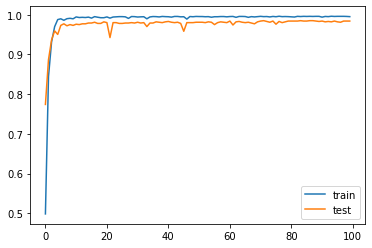

In [17]:
for idx in range(len(k_fold_val_accs)):
    plt.figure()
    plt.plot(k_fold_accs[idx], label="train")
    plt.plot(k_fold_val_accs[idx], label="test")
    plt.legend()
    plt.show()

In [18]:
'''
losses_k_hops = []
accs_k_hops = []

for hop in range(1, 6):
    
    model = HACModel(in_channels, num_class, hop).to('cuda')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    losses, accs, _, _ = train(model, train_loader, None, optimizer, loss_fn, device, num_epochs)
    
    losses_k_hops.append(losses)
    accs_k_hops.append(accs)
'''

"\nlosses_k_hops = []\naccs_k_hops = []\n\nfor hop in range(1, 6):\n    \n    model = HACModel(in_channels, num_class, hop).to('cuda')\n    loss_fn = nn.CrossEntropyLoss()\n    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)\n    \n    losses, accs, _, _ = train(model, train_loader, None, optimizer, loss_fn, device, num_epochs)\n    \n    losses_k_hops.append(losses)\n    accs_k_hops.append(accs)\n"

In [19]:
'''
plt.figure()
for idx, accs in enumerate(accs_k_hops):
    plt.plot(accs, label=str(idx + 1))
    print(np.array(accs).mean())
plt.ylim(0.9, 1.0)
plt.legend()
plt.show()
'''

'\nplt.figure()\nfor idx, accs in enumerate(accs_k_hops):\n    plt.plot(accs, label=str(idx + 1))\n    print(np.array(accs).mean())\nplt.ylim(0.9, 1.0)\nplt.legend()\nplt.show()\n'

In [20]:
model_path

'hac\\trained_model\\gcn\\gestures'

In [21]:
model

HACModel(
  (data_bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gcns): ModuleList(
    (0): GCN(
      (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
      (residual): Sequential(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): GCN(
      (conv): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (residual): Sequential(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): GCN(
      (conv): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      (residual): Sequential(
        (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (edge_importances): ParameterList(
  

In [22]:
trained_model = HACModel(in_channels, num_class, k_hop=2, mode=mode).to(device)

In [23]:
model_name = "best_model.pth"

In [24]:
trained_model.load_state_dict(torch.load(os.path.join(model_path, model_name)))

<All keys matched successfully>